# Homework Assignment - ECG heartbeat classification using PCA/ICA dimensionality reduction and SVM classifier

The goal of this project is to classify ECG heat beats using Support Vector Machines (SVM's).

* Before classification, different data cleansing techniques (Denoising & Baseline-removal) will be evaluated together with dimensionality reduction methods such as PCA (Principal Component Analysis) and ICA (Independent Component Analysis).


* Data Source: 
    - MIT-BIH: The Massachusetts Institute of Technology – Beth Israel Hospital Arrhythmia Database
        - 48 records of 30 min each
        - Download from PhysioNet (https://physionet.org/physiobank/database/#ecg)
        

**Heart beat - the fiducial points (Source: Wikipedia):**



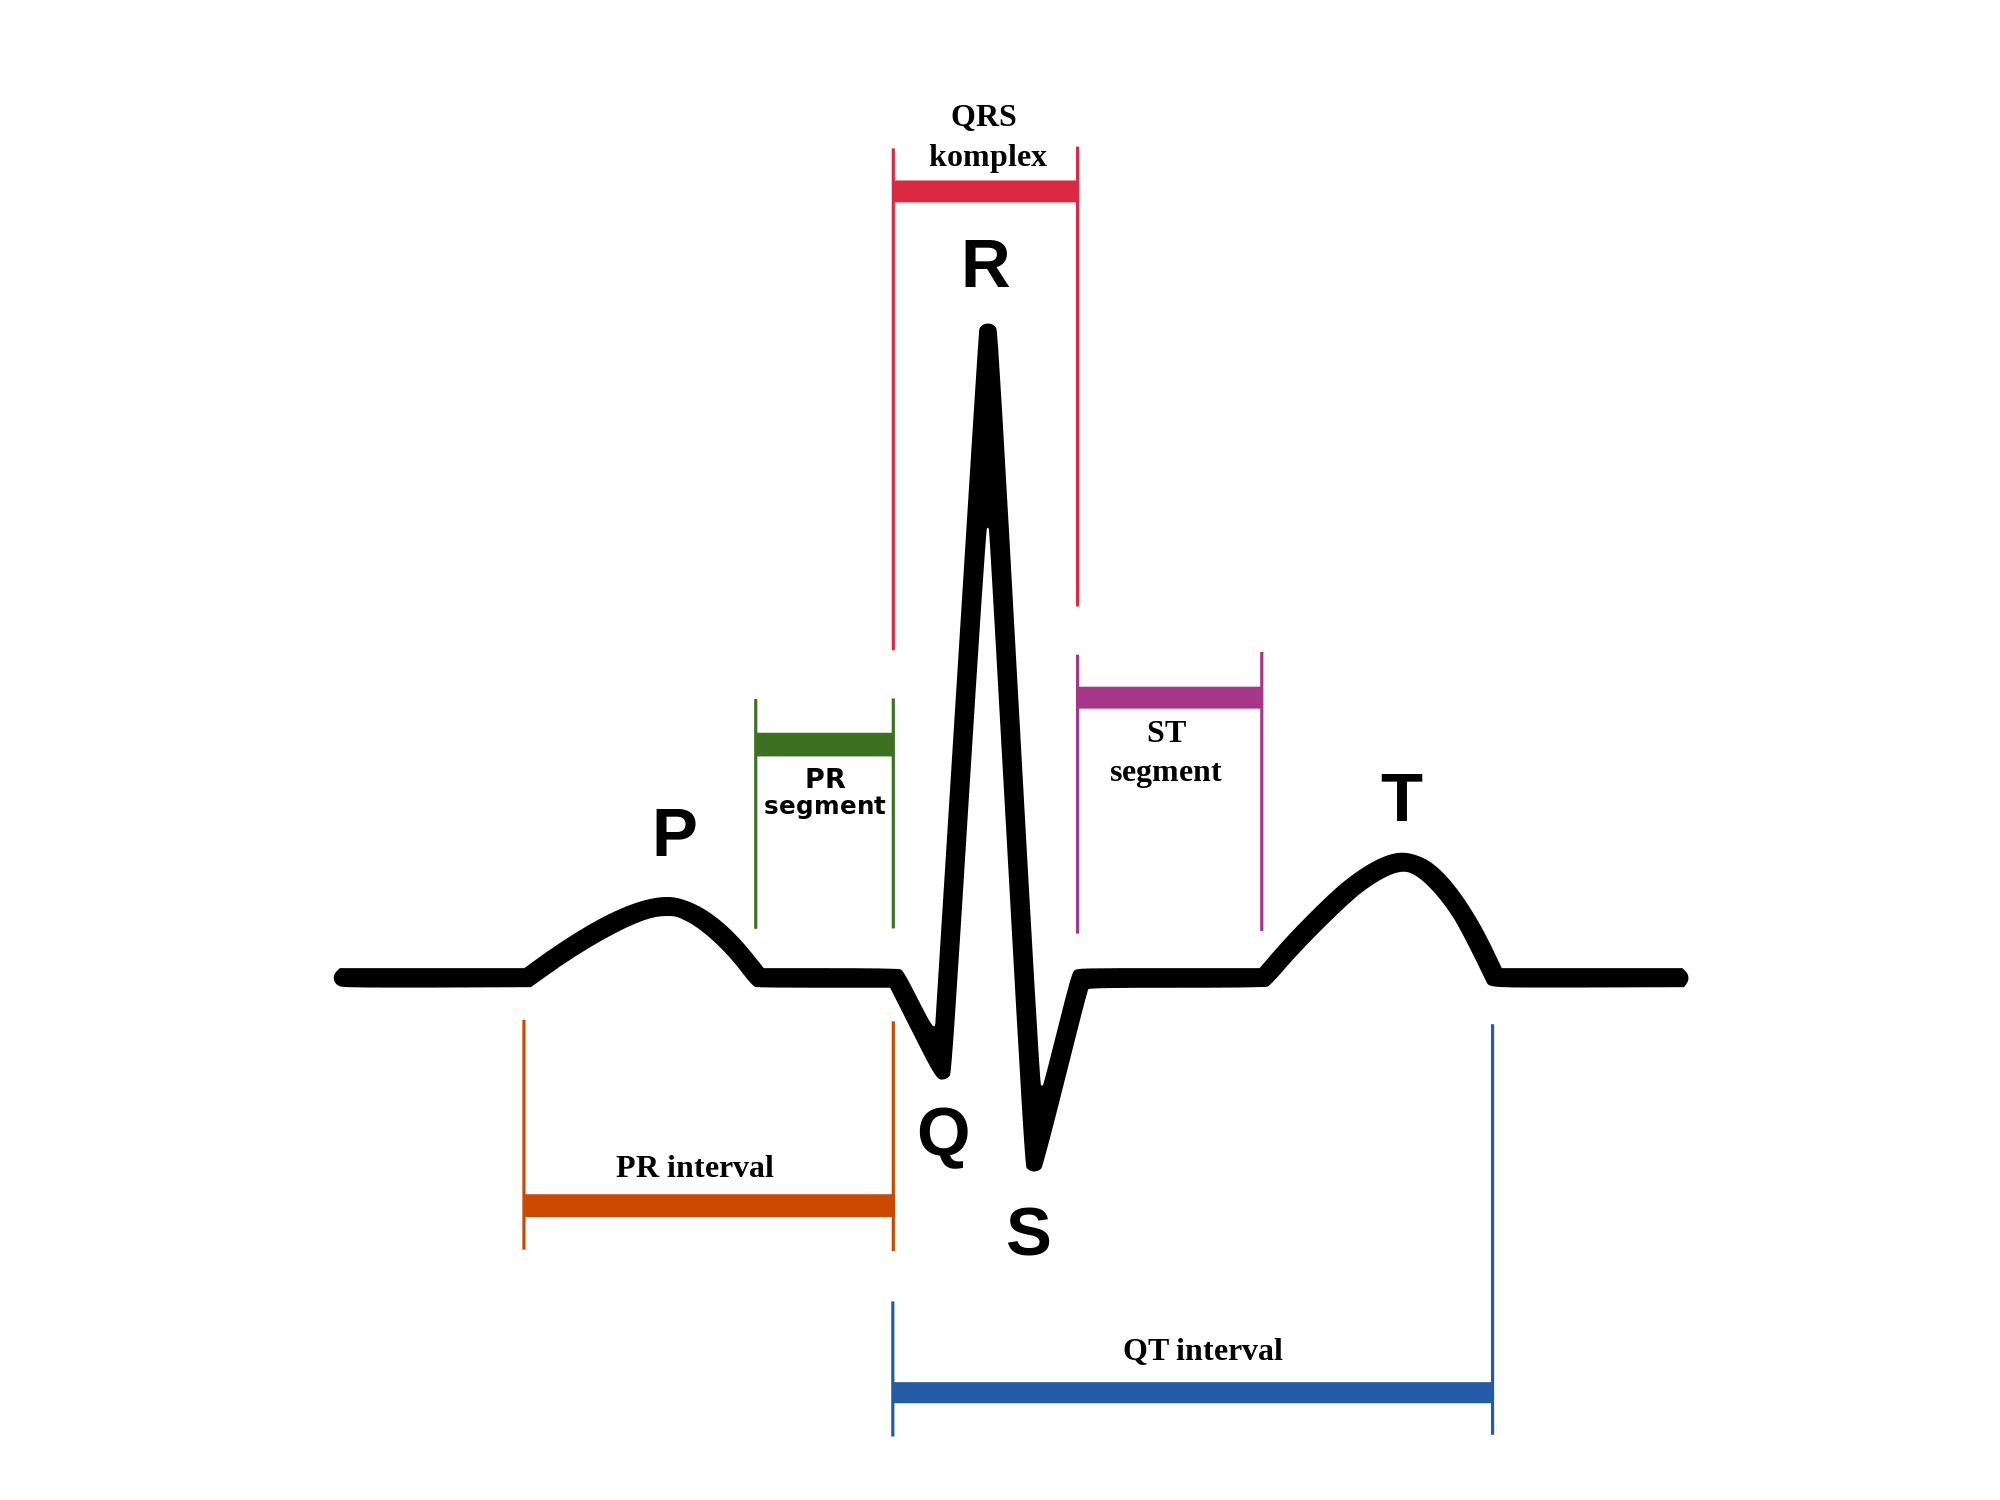

In [9]:
from IPython.display import Image
basewidth = 650
Image("img/PQRST.png", width="650")

**Types of heartbeats to be classified :** (standards by the Association for the Advancement of Medical Instrumentation (AAMI))

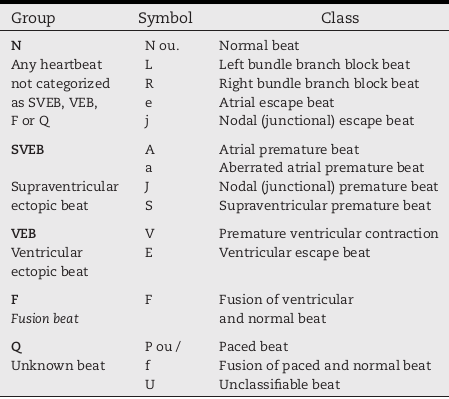

In [2]:
from IPython.display import Image
basewidth = 650
Image("img/beat_types.png", width="450")

 (Source: "ECG-based heartbeat classification for arrhythmia detection: A survey", da S. Luz, Schwartz,Cámara-Chávez, Menotti)

### Plan of procedure

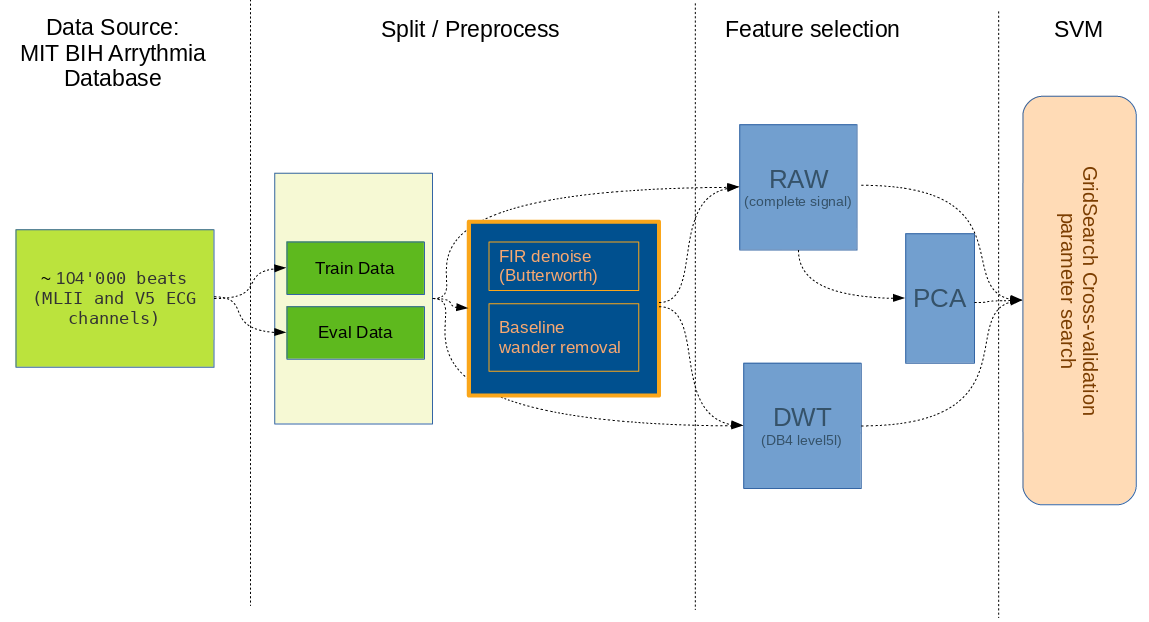

In [12]:
from IPython.display import Image
basewidth = 650
Image("img/action_plan.png")


### Input samples

In [1]:
import pywt
import pywt.data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal


##### a) Single raw beat (showing both ECG channels: 'MLII' and 'V5' )

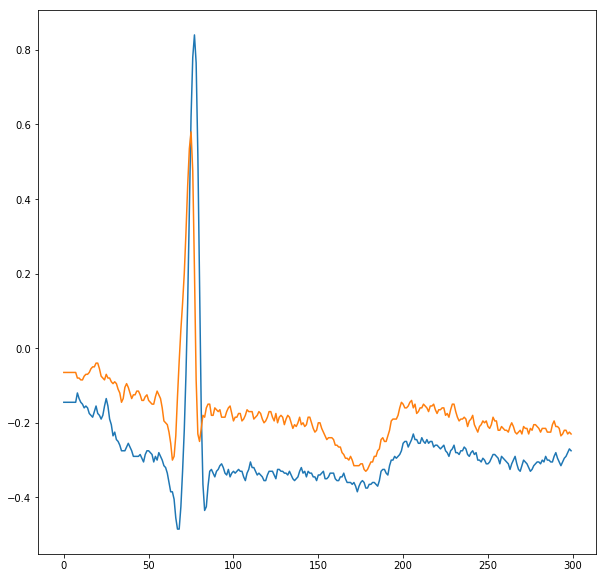

In [2]:
df=pd.read_csv('data/100_ALL_samples.csv', sep=',',header=0, parse_dates=[0],  squeeze=False)

plt.figure(figsize=(10,10))
plt.plot(df['MLII'].head(300))
plt.plot(df['V5'].head(300))

In [5]:
df.drop(df.index[:1], inplace=True)
#print(df.dtypes)
x=df[['MLII']].head(240).stack().values.flatten()

##### b) Single cleansed beat (using Butterworth filter for denoising)

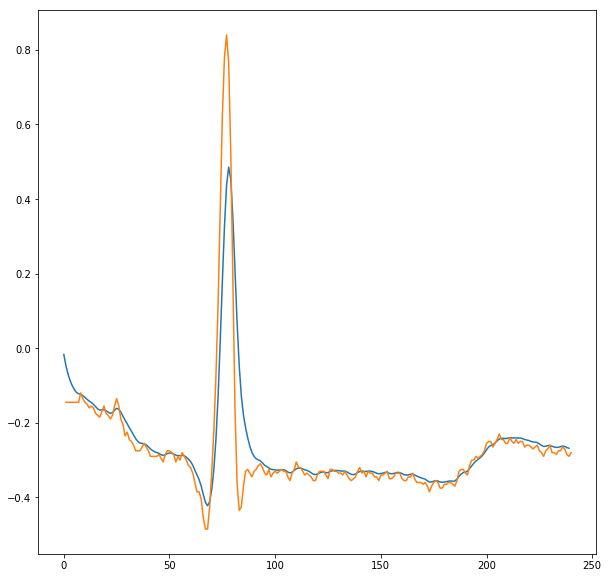

In [6]:
# Butterworth filter: x -> y
lowcut=0.01
highcut=15.0
signal_freq=360
filter_order=1
plt.figure(figsize=(10,10))
nyquist_freq = 0.5*signal_freq
low=lowcut/nyquist_freq
high=highcut/nyquist_freq

b, a = signal.butter(filter_order, [low,high], btype="band")
y = signal.lfilter(b, a, x)
plt.plot(y)
plt.plot(df['MLII'].head(240))

## A series of consecutive beats

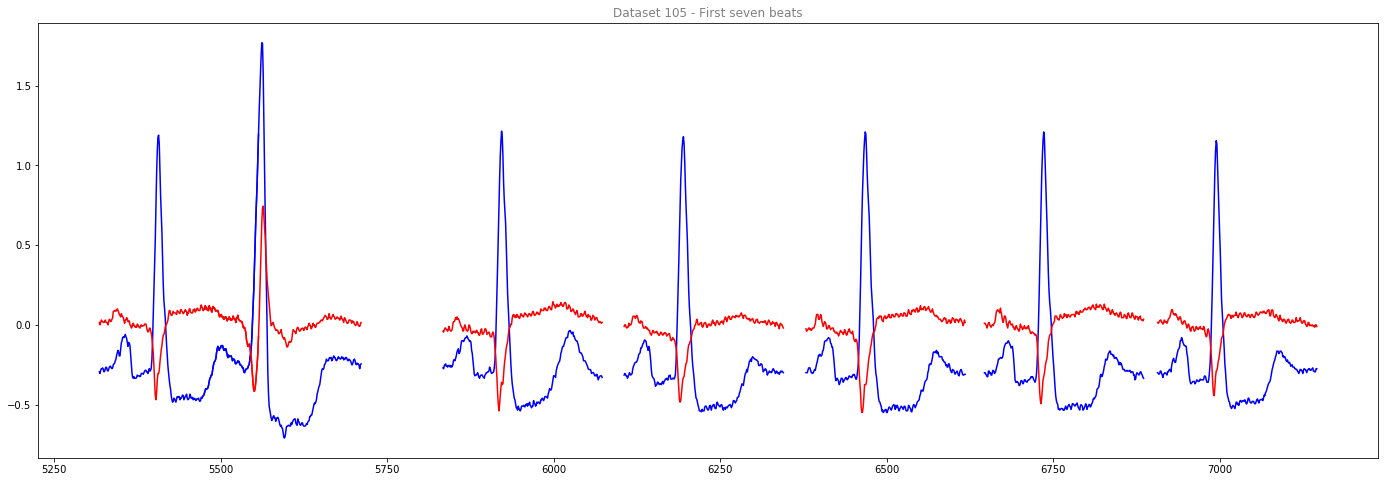

In [7]:
dfall=pd.read_csv('./data/105_ALL_samples.csv', sep=',',header=0,   squeeze=False)
dfseg=pd.read_csv('./data/105_ALL_QRS.csv', sep=',',header=0, parse_dates=[0],  squeeze=False)
dfann=pd.read_csv('./data/105_ALL_ANN.csv', sep=',',header=0, parse_dates=[0],  squeeze=False)
dfrri=pd.read_csv('./data/105_ALL_RRI.csv', sep=',',header=0)
#df.drop(df.index[:1], inplace=True)
%matplotlib inline

pattern = '[()]p.*p[)]'
#dfseg['Type'].str.contains('p')
dfnew = dfseg.reset_index().groupby('Type')['index'].apply(np.array)
dfnew2 = dfseg.reset_index().groupby('Type')['sample'].apply(np.array)

alist = dfnew['(']
blist = dfnew[')']
plist=dfnew['p']
Nlist=dfnew['N']
tlist=dfnew['t']

begpList = [];
endpList = [];
begNList = [];
endNList = [];
begtList = [];
endtList = [];
sliceList = [];
slicepList = [];
sliceNList = [];
slicetList = [];
sliceNtList = [];
slicepNtList = [];
mixList = [];
mixpList = [];



mixpNtList = [];
begQRSList = [];
endQRSList = [];

for w in dfnew['N']:
    #print(w)
    p_prev = [ n for n,i in enumerate(plist) if i< w][-1]
    try:
        t_prev = [ n for n,i in enumerate(tlist) if i< w][-1]
    except IndexError:
        t_prev = -1 
    if (plist[p_prev] < tlist[t_prev]) and (t_prev >= 0):
        QRSbegin = [ n for n,i in enumerate(alist) if i< w][-1]
    else:
        QRSbegin = [ n for n,i in enumerate(alist) if i< plist[p_prev]][-1]   
    t_next = [ n for n,i in enumerate(tlist) if i> w][0]
    QRSend = [ n for n,i in enumerate(blist) if i> tlist[t_next]][0]
    #print(dfseg['sample'][pbegin])
    begQRSList.append(QRSbegin);
    endQRSList.append(QRSend);
     
mixpNtList = tuple(zip(begQRSList,endQRSList)) 

for v in mixpNtList:
    #print(x)
    slicepNtList.append(tuple((dfnew2['('][v[0]],dfnew2[')'][v[1]])))

#-----------------

preX = 89;
postX = 150;
begNList = [];
endNList = [];
mixNList = [];
sliceNList = [];
    
#for y in dfann['sample']:
for index, row in dfann.iterrows():
    #Nbegin = y - preX;
    Nbegin = row['sample'] - preX;
    #Nend = y + postX;
    Nend = row['sample'] + postX;
    begNList.append(Nbegin);
    endNList.append(Nend);

mixNList = tuple(zip(begNList,endNList)) 
mixNList[-1]
        

plt.figure(figsize=(24,8))

for x in range(20,27):
    dfseg1 = dfall[(dfall['sample'] >= mixNList[x][0]) & (dfall['sample'] <= mixNList[x][1])]
    plt.title('Dataset 105 - Seven consecutive beats', color="grey")
    plt.plot(dfseg1['MLII'], color="blue")
    plt.plot(dfseg1['V5'], color="red")

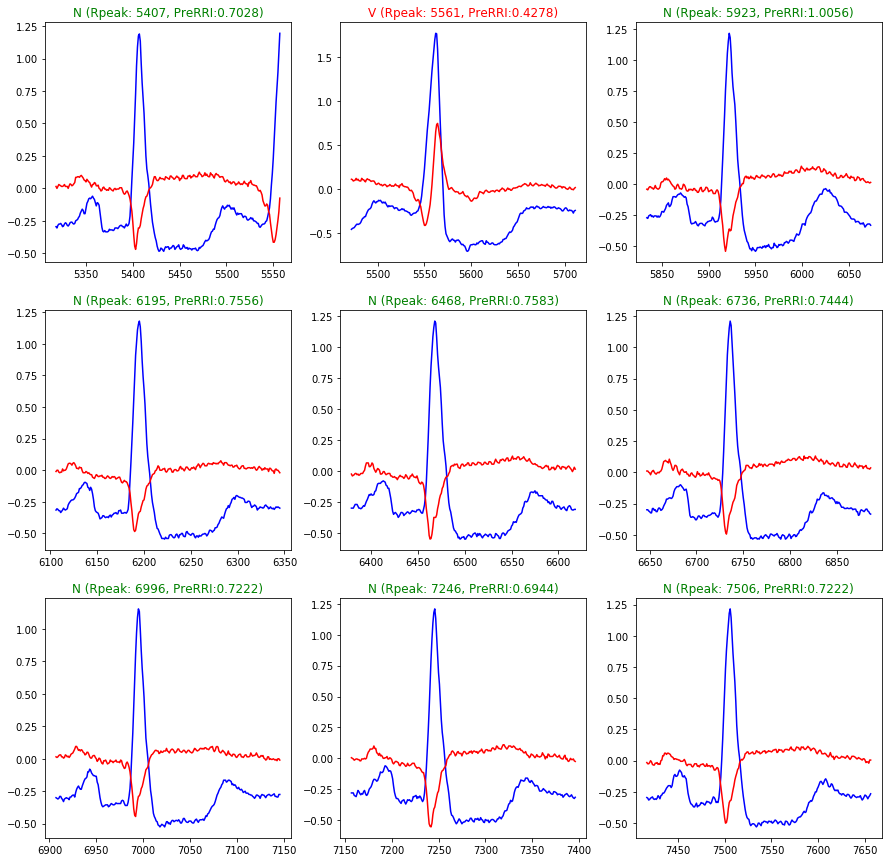

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15,15))

i = 20 # 20 115        
y = -1
for x in range(0,9):
    if x % 3 == 0:
        y=y+1
    dfseg1 = dfall[(dfall['sample'] >= mixNList[x+i][0]) & (dfall['sample'] <= mixNList[x+i][1])]
    
    if str(dfann['Type'][x+i]) != 'N':
        axes[y, x % 3].set_title('my title', color="red")
    else:
        axes[y, x % 3].set_title('my title', color="green")
  
    axes[y, x % 3].plot(dfseg1['MLII'], color="blue")
    axes[y, x % 3].plot(dfseg1['V5'], color="red")
    axes[y, x % 3].set_title(str(dfann['Type'][x+i]) + ' (Rpeak: ' + str(dfann['sample'][x+i]) + ', PreRRI:' + str(float("{0:.4f}".format(dfrri['wPre'][x+i-1]))) + ')' )


# Wavelet decomposition

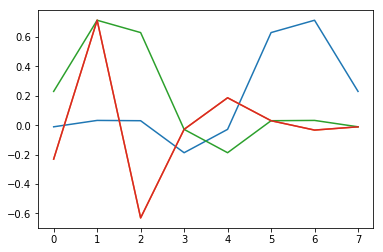

In [10]:
w = pywt.Wavelet('db4')
#print(w.dec_lo)
plt.plot(w.dec_lo)
plt.plot(w.dec_hi)
plt.plot(w.rec_lo)
plt.plot(w.dec_hi)

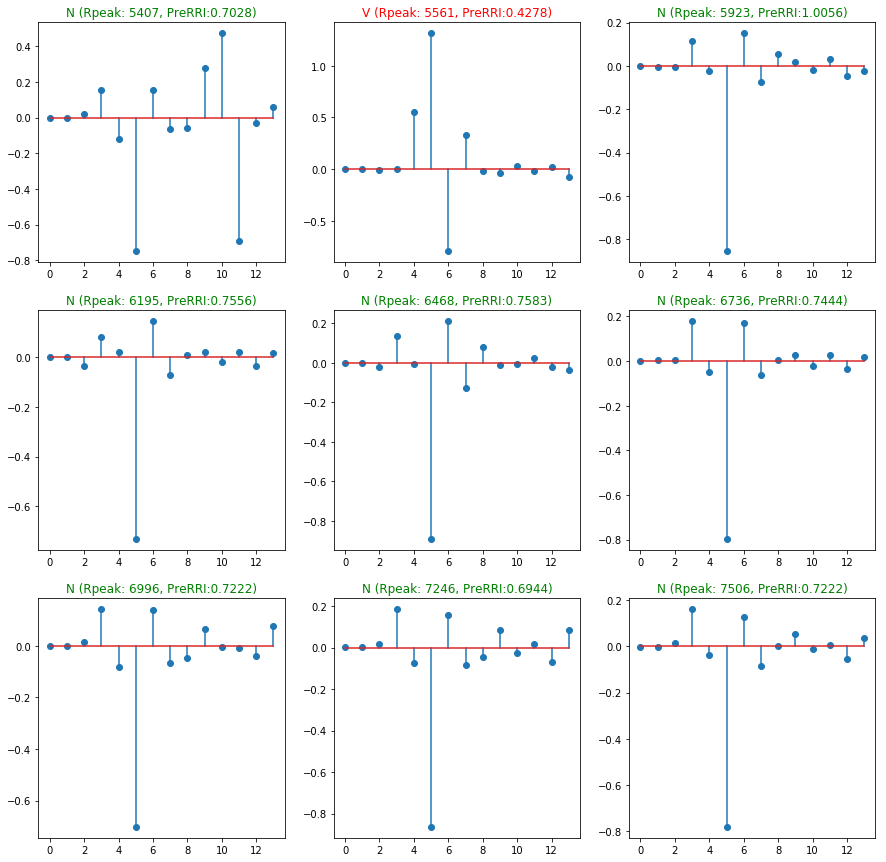

In [9]:
# Wavelet decomposition of 105 
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15,15))

i = 20 # 20 115         
y = -1
for x in range(0,9):
    if x % 3 == 0:
        y=y+1
    dfseg1 = dfall[(dfall['sample'] >= mixNList[x+i][0]) & (dfall['sample'] <= mixNList[x+i][1])]
    coeffsMLII = pywt.wavedec(dfseg1['MLII'], w )
    coeffsV5 = pywt.wavedec(dfseg1['V5'], w )
    
    if str(dfann['Type'][x+i]) != 'N':
        axes[y, x % 3].set_title('my title', color="red")
    else:
        axes[y, x % 3].set_title('my title', color="green")
  
    #axes[y, x % 3].plot(pywt.waverec(coeffsMLII[:-3] + [None] * 3, w))
    #axes[y, x % 3].plot(pywt.waverec(coeffsV5[:-3] + [None] * 3, w))
    #axes[y, x % 3].stem(coeffsMLII[3], color="blue")
    axes[y, x % 3].stem(coeffsV5[1])
    axes[y, x % 3].set_title(str(dfann['Type'][x+i]) + ' (Rpeak: ' + str(dfann['sample'][x+i]) + ', PreRRI:' + str(float("{0:.4f}".format(dfrri['wPre'][x+i-1]))) + ')' )
    

### Creating the train and test Datasets

In [3]:
import os, sys
sys.path.append("./module")
import svm_ecg as svm_ecg

# Define segment start/end relative to R-peak:
preX = 89                  #19 89
postX = 150                # 20 150

# Load DS1 - train and DS2 - eval datasets
# Define feature extract methods and RRI / Cleanse options 

ds1_all, ds1_ann, ds1_seg, ds1_lab = svm_ecg.create_DS("1",preX,postX,feature_extract_methods=['DWT'],add_rri=True, cleanse=False)
ds2_all, ds2_ann, ds2_seg, ds2_lab = svm_ecg.create_DS("2",preX,postX,feature_extract_methods=['DWT'],add_rri=True, cleanse=False)

##### Distribution of samples 

(array([0, 1, 2, 3, 4], dtype=int32), array([46056,   943,  4006,   414,   267]))
(array([0, 1, 2, 3, 4], dtype=int32), array([44465,  1836,  3225,   388,   743]))


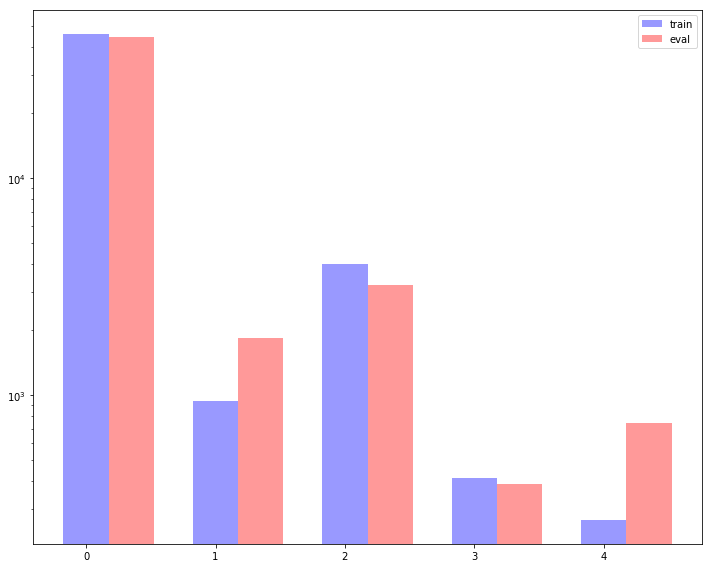

In [4]:
plt.figure(figsize=(10,8)) 

train_data = ds1_seg
train_labels = np.asarray(ds1_lab, dtype=np.int32)
eval_data = ds2_seg
eval_labels = np.array(ds2_lab, dtype=np.int32)

# The total counts for all classes:
# Beat types:
# 0 - Normal beat  (N)
# 1 - Premature ventricular contraction (V)
# 2 - Atrial premature beat (SVEB)
# 3 - Fusion of ventricular and normal beat (F)
# 4 - Unclassifiable beat (Q)

print(np.unique(train_labels, return_counts=True))
print(np.unique(eval_labels, return_counts=True))
x1=np.unique(train_labels, return_counts=True)
x2=np.unique(eval_labels, return_counts=True)

opacity = 0.4
bar_width = 0.35
index = np.arange(5)

a1 = plt.bar(index,  x1[1],  bar_width, alpha=opacity,   color='b',label='train')
a2 = plt.bar(index+bar_width, x2[1],  bar_width, alpha=opacity,   color='r',label='eval')

plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()


#### Sample linear SVM model fitting

In [4]:
from sklearn.svm import SVC
model = SVC(kernel='linear', class_weight='balanced', probability=False)

model.fit(ds1_seg, ds1_lab)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [6]:
# 418. segment -> this is the first irregular beat; type = V (1)
model.decision_function(ds1_seg)[418]
model.score(ds2_seg, ds2_lab)
print(model.predict([ds1_seg[418]]))

[1]


### Training the SVM model using model selection

In order to compensate for the the largely unbalanced class probabilities, "balanced" class weight (penalty inversely proporational to class size ratios) and probability sampling will be used. Due to probability sampling, the result generation is greatly slowd down.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

model = SVC(class_weight='balanced',probability=True)
param_grid = {'C': [1, 10, 50, 75, 100],
              'gamma': [0.0001, 0.001, 0.005, 0.01, 0.05],
              'kernel': ('linear','rbf', 'poly')}
grid = GridSearchCV(model, param_grid,cv=5)

grid.fit(ds1_seg, ds1_lab)


In [ ]:
print(grid.best_params_)

In [ ]:
model = grid.best_estimator_
y_pred = model.predict(ds2_seg)

### Sample confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
plt.figure(figsize=(8,8))

y_pred = model.predict(ds2_seg)
y_true = ds2_lab

confusion_matrix(y_true, y_pred)

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, linewidths=.3, center=4000, robust=True, 
            xticklabels=["N","V","SVEB","F","Q"],
            yticklabels=["N","V","SVEB","F","Q"])

plt.xlabel('true label', fontsize=18)
plt.ylabel('predicted label', fontsize=18);

### Sample classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["N","V","SVEB","F","Q"]))

### Results obtained for various input feature selections & SVM models

| __Input feature selected__ | __Cleanse__ | __RRI__ | __Weighted Averages__ | __SVM Model best param__ |
|------|------|------|------|------|
|RAW |   |  X | Weighted Averages | SVM Model best param |